In this example, we will use a simple Dual Moving Average Crossover (DMAC, not to be confused with MACD) indicator as our entry and exit strategy. We will start with analyzing a single fast and slow window combination, and then move on to some advanced analysis such as building 2D heatmaps to compare multiple combinations and 3D cubes to see how they perform against time. Finally, we will explore how our DMAC strategy compares to holding Bitcoin and trading randomly.

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pytz
from dateutil.parser import parse
import ipywidgets as widgets
from copy import deepcopy
from tqdm import tqdm
import imageio
from IPython import display
import plotly.graph_objects as go
import itertools
import dateparser

In [3]:
# Enter your parameters here
seed = 42
symbol = 'EURUSD'
metric = 'total_return'

start_date = datetime(2017, 1, 1, tzinfo=pytz.utc)  # time period for analysis, must be timezone-aware
end_date = datetime(2020, 1, 1, tzinfo=pytz.utc)
time_buffer = timedelta(days=100)  # buffer before to pre-calculate SMA/EMA, best to set to max window
freq = '1D'

vbt.settings.portfolio['init_cash'] = 100.  # 100$
vbt.settings.portfolio['fees'] = 0.0025  # 0.25%
vbt.settings.portfolio['slippage'] = 0.0025  # 0.25%

In [4]:
# Prepare data with data buffer
data_buffer = 100 # data buffer before to pre-calculate SMA/EMA, best to set to max window

ohlcv_wbuf = pd.read_csv('data_d1/EURUSD_d1.csv', index_col=0, parse_dates=[0])
ohlcv_wbuf = ohlcv_wbuf.iloc[:, :-2]

backtest_range = (ohlcv_wbuf.index >= start_date) & (ohlcv_wbuf.index <= end_date) # range of data to backtest

ohlcv_wbuf = pd.concat(
    [
        ohlcv_wbuf.loc[ohlcv_wbuf.index < start_date].iloc[-data_buffer:], 
        ohlcv_wbuf.loc[backtest_range]
    ]
)

print(ohlcv_wbuf.shape)
print(ohlcv_wbuf.columns)

(877, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [5]:
# Create a copy of data without time buffer
wobuf_mask = (ohlcv_wbuf.index >= start_date) & (ohlcv_wbuf.index <= end_date) # mask without buffer

ohlcv = ohlcv_wbuf.loc[wobuf_mask]

print(ohlcv.shape)

(777, 5)


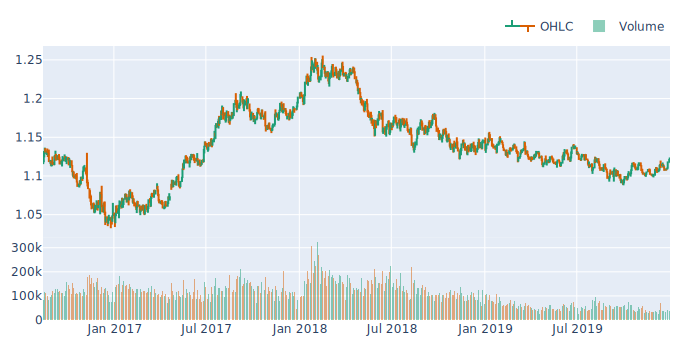

In [6]:
# Plot the OHLC data
ohlcv_wbuf.vbt.ohlcv.plot().show_svg() 
# remove show_svg() to display interactive chart!

## Single window combination

Perform a single test to see how our DMAC strategy compares to the hold strategy.

In [7]:
fast_window = 30
slow_window = 80

In [8]:
# Pre-calculate running windows on data with time buffer
fast_ma = vbt.MA.run(ohlcv_wbuf['Open'], fast_window)
slow_ma = vbt.MA.run(ohlcv_wbuf['Open'], slow_window)

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)

(877,)
(877,)


In [9]:
# Remove time buffer
fast_ma = fast_ma[wobuf_mask]
slow_ma = slow_ma[wobuf_mask]

# there should be no nans after removing time buffer
assert(~fast_ma.ma.isnull().any()) 
assert(~slow_ma.ma.isnull().any())

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)

(777,)
(777,)


In [10]:
# Generate crossover signals
dmac_entries = fast_ma.ma_above(slow_ma, crossover=True)
dmac_exits = fast_ma.ma_below(slow_ma, crossover=True)

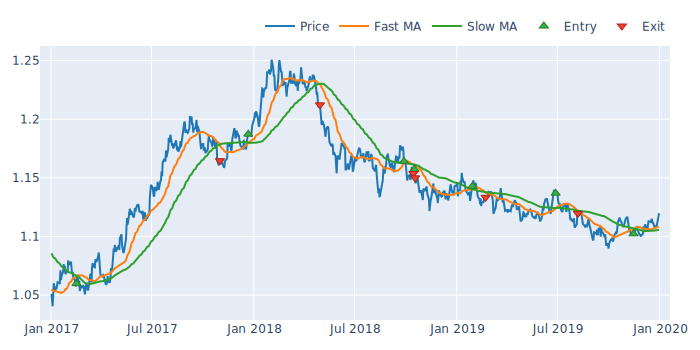

In [11]:
fig = ohlcv['Open'].vbt.plot(trace_kwargs=dict(name='Price'))
fig = fast_ma.ma.vbt.plot(trace_kwargs=dict(name='Fast MA'), fig=fig)
fig = slow_ma.ma.vbt.plot(trace_kwargs=dict(name='Slow MA'), fig=fig)
fig = dmac_entries.vbt.signals.plot_as_entry_markers(ohlcv['Open'], fig=fig)
fig = dmac_exits.vbt.signals.plot_as_exit_markers(ohlcv['Open'], fig=fig)

fig.show_svg()

In [12]:
# Distribution of signals
print(dmac_entries.vbt.signals.num_signals(), dmac_exits.vbt.signals.num_signals())
print(dmac_entries.vbt.signals.avg_distance(), dmac_exits.vbt.signals.avg_distance())
print(dmac_entries.vbt.signals.avg_distance(to=dmac_exits))

7 6
118.66666666666667 91.2
55.166666666666664


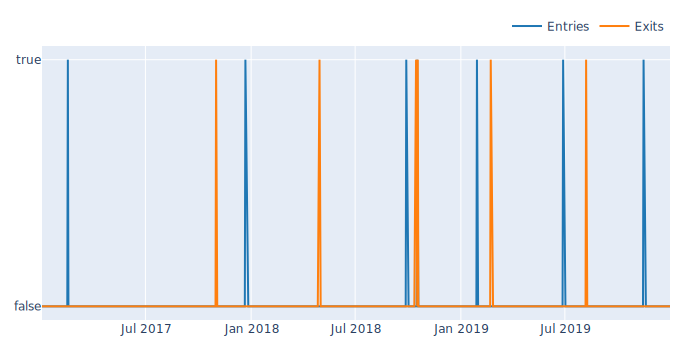

In [13]:
# Plot signals
fig = dmac_entries.vbt.signals.plot(trace_kwargs=dict(name='Entries'))
dmac_exits.vbt.signals.plot(trace_kwargs=dict(name='Exits'), fig=fig).show_svg()

In [15]:
# Build partfolio, which internally calculates the equity curve

# Volume is set to np.inf by default to buy/sell everything
# You don't have to pass freq here because our data is already perfectly time-indexed
dmac_pf = vbt.Portfolio.from_signals(ohlcv['Close'], dmac_entries, dmac_exits, freq='d')

# Print stats
print(dmac_pf.stats())

Start                    2017-01-02 00:00:00+00:00
End                      2019-12-31 00:00:00+00:00
Duration                         777 days 00:00:00
Initial Cash                                 100.0
Total Profit                              2.357594
Total Return [%]                          2.357594
Benchmark Return [%]                      7.380476
Position Coverage [%]                    46.718147
Max Drawdown [%]                         11.290214
Avg Drawdown [%]                          1.386906
Max Drawdown Duration            485 days 00:00:00
Avg Drawdown Duration             30 days 10:00:00
Trade Count                                      6
Win Rate [%]                             33.333333
Best Trade [%]                            7.792534
Worst Trade [%]                          -2.484151
Avg Trade [%]                             0.276035
Max Trade Duration               184 days 00:00:00
Avg Trade Duration                55 days 04:00:00
Expectancy                     

   id  col       size  entry_idx  entry_price  entry_fees  exit_idx  \
0   0    0  93.230269         33     1.069938    0.249377       217   
1   1    0  90.410037        254     1.189075    0.268761       343   
2   2    0  93.194944        452     1.163171    0.271004       463   
3   3    0  92.896650        465     1.152895    0.267750       466   
4   4    0  92.127584        537     1.146048    0.263957       555   
5   5    0  90.908458        645     1.139812    0.259046       673   
6   6    0  91.200979        745     1.108003    0.252627       776   

   exit_price  exit_fees       pnl    return  direction  status  position_id  
0    1.158886   0.270108  7.773101  0.077925          0       1            0  
1    1.205010   0.272362  0.899529  0.008367          0       1            1  
2    1.154965   0.269092 -1.304791 -0.012037          0       1            2  
3    1.142257   0.265280 -1.521251 -0.014204          0       1            3  
4    1.130367   0.260345 -1.968952 -

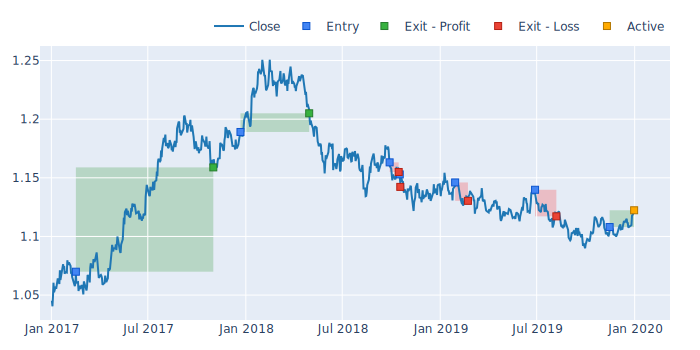

In [16]:
# Plot trades
print(dmac_pf.trades.records)
dmac_pf.trades.plot().show_svg()

In [17]:
# Now build portfolio for a "Hold" strategy
# Here we buy once at the beginning and sell at the end
hold_entries = pd.Series.vbt.signals.empty_like(dmac_entries)
hold_entries.iloc[0] = True
hold_exits = pd.Series.vbt.signals.empty_like(hold_entries)
hold_exits.iloc[-1] = True
hold_pf = vbt.Portfolio.from_signals(ohlcv['Close'], hold_entries, hold_exits)

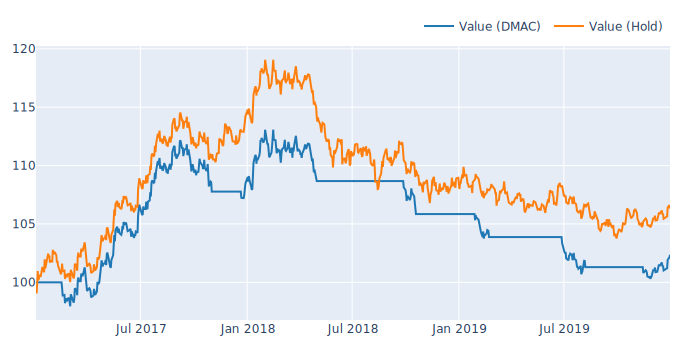

In [18]:
# Equity
fig = dmac_pf.value().vbt.plot(trace_kwargs=dict(name='Value (DMAC)'))
hold_pf.value().vbt.plot(trace_kwargs=dict(name='Value (Hold)'), fig=fig).show_svg()

Now we will implement an interactive window slider to easily compare windows by their performance.

In [19]:
min_window = 2
max_window = 100

In [20]:
perf_metrics = ['total_return', 'positions.win_rate', 'positions.expectancy', 'max_drawdown']
perf_metric_names = ['Total return', 'Win rate', 'Expectancy', 'Max drawdown']

windows_slider = widgets.IntRangeSlider(
    value=[fast_window, slow_window],
    min=min_window,
    max=max_window,
    step=1,
    layout=dict(width='500px'),
    continuous_update=True
)
dmac_fig = None
dmac_img = widgets.Image(
    format='png',
    width=vbt.settings['plotting']['layout']['width'],
    height=vbt.settings['plotting']['layout']['height']
)
metrics_html = widgets.HTML()

def on_value_change(value):
    global dmac_fig
    
    # Calculate portfolio
    fast_window, slow_window = value['new']
    fast_ma = vbt.MA.run(ohlcv_wbuf['Open'], fast_window)
    slow_ma = vbt.MA.run(ohlcv_wbuf['Open'], slow_window)
    fast_ma = fast_ma[wobuf_mask]
    slow_ma = slow_ma[wobuf_mask]
    dmac_entries = fast_ma.ma_above(slow_ma, crossover=True)
    dmac_exits = fast_ma.ma_below(slow_ma, crossover=True)
    dmac_pf = vbt.Portfolio.from_signals(ohlcv['Close'], dmac_entries, dmac_exits)

    # Update figure
    if dmac_fig is None:
        dmac_fig = ohlcv['Open'].vbt.plot(trace_kwargs=dict(name='Price'))
        fast_ma.ma.vbt.plot(trace_kwargs=dict(name='Fast MA'), fig=dmac_fig)
        slow_ma.ma.vbt.plot(trace_kwargs=dict(name='Slow MA'), fig=dmac_fig)
        dmac_entries.vbt.signals.plot_as_entry_markers(ohlcv['Open'], fig=dmac_fig)
        dmac_exits.vbt.signals.plot_as_exit_markers(ohlcv['Open'], fig=dmac_fig)
    else:
        with dmac_fig.batch_update():
            dmac_fig.data[1].y = fast_ma.ma
            dmac_fig.data[2].y = slow_ma.ma
            dmac_fig.data[3].x = ohlcv['Open'].index[dmac_entries]
            dmac_fig.data[3].y = ohlcv['Open'][dmac_entries]
            dmac_fig.data[4].x = ohlcv['Open'].index[dmac_exits]
            dmac_fig.data[4].y = ohlcv['Open'][dmac_exits]
    dmac_img.value = dmac_fig.to_image(format="png")
    
    # Update metrics table
    sr = pd.Series([dmac_pf.getattr(m) for m in perf_metrics], 
                   index=perf_metric_names, name='Performance')
    metrics_html.value = sr.to_frame().style.set_properties(**{'text-align': 'right'}).render()
    
windows_slider.observe(on_value_change, names='value')
on_value_change({'new': windows_slider.value})

dashboard = widgets.VBox([
    widgets.HBox([widgets.Label('Fast and slow window:'), windows_slider]),
    dmac_img,
    metrics_html
])
dashboard

In [21]:
dashboard.close() # after using, release memory and notebook metadata

## Multiple window combinations

Calculate the performance of each window combination in a vectorized way and display the results as a heatmap.

In [22]:
%%time
# Pre-calculate running windows on data with time buffer
fast_ma, slow_ma = vbt.MA.run_combs(
    ohlcv_wbuf['Open'], np.arange(min_window, max_window+1), 
    r=2, short_names=['fast_ma', 'slow_ma'])

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)
print(fast_ma.ma.columns)
print(slow_ma.ma.columns)

(877, 4851)
(877, 4851)
Int64Index([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
            ...
            96, 96, 96, 96, 97, 97, 97, 98, 98, 99],
           dtype='int64', name='fast_ma_window', length=4851)
Int64Index([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
            ...
             97,  98,  99, 100,  98,  99, 100,  99, 100, 100],
           dtype='int64', name='slow_ma_window', length=4851)
Wall time: 448 ms


In [23]:
# Remove time buffer
fast_ma = fast_ma[wobuf_mask]
slow_ma = slow_ma[wobuf_mask]

print(fast_ma.ma.shape)
print(slow_ma.ma.shape)

(777, 4851)
(777, 4851)


In [24]:
# We perform the same steps, but now we have 4851 columns instead of 1
# Each column corresponds to a pair of fast and slow windows
# Generate crossover signals
dmac_entries = fast_ma.ma_above(slow_ma, crossover=True)
dmac_exits = fast_ma.ma_below(slow_ma, crossover=True)

print(dmac_entries.columns) # the same for dmac_exits

MultiIndex([( 2,   3),
            ( 2,   4),
            ( 2,   5),
            ( 2,   6),
            ( 2,   7),
            ( 2,   8),
            ( 2,   9),
            ( 2,  10),
            ( 2,  11),
            ( 2,  12),
            ...
            (96,  97),
            (96,  98),
            (96,  99),
            (96, 100),
            (97,  98),
            (97,  99),
            (97, 100),
            (98,  99),
            (98, 100),
            (99, 100)],
           names=['fast_ma_window', 'slow_ma_window'], length=4851)


In [25]:
# Build portfolio
dmac_pf = vbt.Portfolio.from_signals(ohlcv['Close'], dmac_entries, dmac_exits)

In [26]:
# Calculate performance of each window combination
dmac_perf = dmac_pf.getattr(metric)

print(dmac_perf.shape)
print(dmac_perf.index)

(4851,)
MultiIndex([( 2,   3),
            ( 2,   4),
            ( 2,   5),
            ( 2,   6),
            ( 2,   7),
            ( 2,   8),
            ( 2,   9),
            ( 2,  10),
            ( 2,  11),
            ( 2,  12),
            ...
            (96,  97),
            (96,  98),
            (96,  99),
            (96, 100),
            (97,  98),
            (97,  99),
            (97, 100),
            (98,  99),
            (98, 100),
            (99, 100)],
           names=['fast_ma_window', 'slow_ma_window'], length=4851)


In [27]:
dmac_perf.idxmax() # your optimal window combination

(50, 83)

In [28]:
# Convert this array into a matrix of shape (99, 99): 99 fast windows x 99 slow windows
dmac_perf_matrix = dmac_perf.vbt.unstack_to_df(symmetric=True, 
    index_levels='fast_ma_window', column_levels='slow_ma_window')

print(dmac_perf_matrix.shape)

(99, 99)


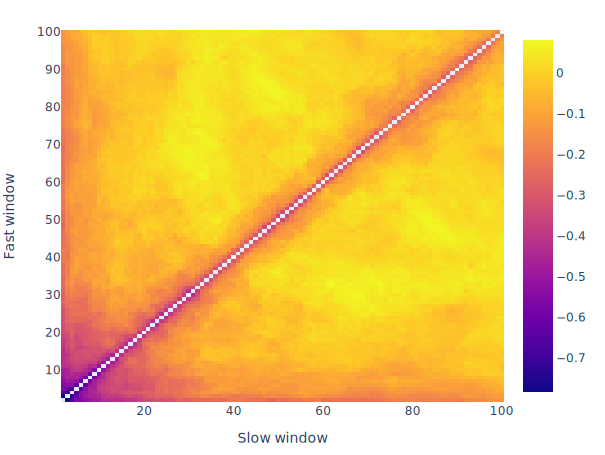

In [29]:
dmac_perf_matrix.vbt.heatmap(
    xaxis_title='Slow window', 
    yaxis_title='Fast window').show_svg()
# remove show_svg() for interactivity

Now we will implement an interactive date range slider to easily compare heatmaps over time.

In [30]:
def dmac_pf_from_date_range(from_date, to_date):
    # Portfolio from MA crossover, filtered by time range
    range_mask = (ohlcv.index >= from_date) & (ohlcv.index <= to_date)
    range_fast_ma = fast_ma[range_mask] # use our variables defined above
    range_slow_ma = slow_ma[range_mask]
    dmac_entries = range_fast_ma.ma_above(range_slow_ma, crossover=True)
    dmac_exits = range_fast_ma.ma_below(range_slow_ma, crossover=True)
    dmac_pf = vbt.Portfolio.from_signals(ohlcv.loc[range_mask, 'Close'], dmac_entries, dmac_exits)
    return dmac_pf

%time dmac_pf_from_date_range(str(ohlcv.index[0]), str(ohlcv.index[-1])).wrapper.shape

Wall time: 511 ms


(777, 4851)

In [31]:
def rand_pf_from_date_range(from_date, to_date):
    # Portfolio from random strategy, filtered by time range
    range_mask = (ohlcv.index >= from_date) & (ohlcv.index <= to_date)
    range_fast_ma = fast_ma[range_mask] # use our variables defined above
    range_slow_ma = slow_ma[range_mask]
    dmac_entries = range_fast_ma.ma_above(range_slow_ma, crossover=True)
    dmac_exits = range_fast_ma.ma_below(range_slow_ma, crossover=True)
    rand_entries = dmac_entries.vbt.signals.shuffle(seed=seed) # same number of signals as in dmac
    rand_exits = rand_entries.vbt.signals.generate_random_exits(seed=seed)
    rand_pf = vbt.Portfolio.from_signals(ohlcv.loc[range_mask, 'Close'], rand_entries, rand_exits)
    return rand_pf

%time rand_pf_from_date_range(str(ohlcv.index[0]), str(ohlcv.index[-1])).wrapper.shape

Wall time: 2.11 s


(777, 4851)

In [32]:
def hold_pf_from_date_range(from_date, to_date):
    # Portfolio from holding strategy, filtered by time range
    range_mask = (ohlcv.index >= from_date) & (ohlcv.index <= to_date)
    hold_entries = pd.Series.vbt.signals.empty(range_mask.sum(), index=ohlcv[range_mask].index)
    hold_entries.iloc[0] = True
    hold_exits = pd.Series.vbt.signals.empty_like(hold_entries)
    hold_exits.iloc[-1] = True
    hold_pf = vbt.Portfolio.from_signals(ohlcv.loc[range_mask, 'Close'], hold_entries, hold_exits)
    return hold_pf

%time hold_pf_from_date_range(str(ohlcv.index[0]), str(ohlcv.index[-1])).wrapper.shape

Wall time: 9 ms


(777,)

In [32]:
# TimeSeries (OHLC)
ts_fig = ohlcv.vbt.ohlcv.plot(
    title=symbol, 
    display_volume=False,
    annotations=[dict(
        align='left',
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0.5,
        y=0.9,
        font=dict(size=14),
        bordercolor='black',
        borderwidth=1,
        bgcolor='white'
    )],
    width=700, 
    height=250)

# Histogram (DMAC vs Random)
histogram = vbt.plotting.Histogram(
    trace_names=['Random strategy', 'DMAC strategy'],
    title='%s distribution' % metric,
    xaxis_tickformat='%',
    annotations=[dict(
        y=0, 
        xref='x', 
        yref='paper', 
        showarrow=True, 
        arrowcolor="black",
        arrowsize=1,
        arrowwidth=1,
        arrowhead=1,
        xanchor='left', 
        text='Hold', 
        textangle=0,
        font=dict(size=14),
        bordercolor='black',
        borderwidth=1,
        bgcolor='white',
        ax=0,
        ay=-50,
    )],
    width=700,
    height=250
)

# Heatmap (DMAC vs Holding)
heatmap = vbt.plotting.Heatmap(
    x_labels=np.arange(min_window, max_window+1),
    y_labels=np.arange(min_window, max_window+1),
    trace_kwargs=dict(
        colorbar=dict(
            tickformat='%', 
            ticks="outside"
        ), 
        colorscale='RdBu'),
    title='%s by window' % metric,
    width=650,
    height=420
)

dmac_perf_matrix = None
rand_perf_matrix = None
hold_value = None

def update_heatmap_colorscale(perf_matrix):
    # Update heatmap colorscale based on performance matrix
    with heatmap.fig.batch_update():
        heatmap.fig.data[0].zmid = hold_value
        heatmap.fig.data[0].colorbar.tickvals = [
            np.nanmin(perf_matrix), 
            hold_value, 
            np.nanmax(perf_matrix)
        ]
        heatmap.fig.data[0].colorbar.ticktext = [
            'Min: {:.0%}'.format(np.nanmin(perf_matrix)).ljust(12), 
            'Hold: {:.0%}'.format(hold_value).ljust(12), 
            'Max: {:.0%}'.format(np.nanmax(perf_matrix)).ljust(12)
        ]
    
def update_histogram(dmac_perf_matrix, rand_perf_matrix, hold_value):
    # Update histogram figure
    with histogram.fig.batch_update():
        histogram.update(
            np.asarray([
                rand_perf_matrix.values.flatten(),
                dmac_perf_matrix.values.flatten()
            ]).transpose()
        )
        histogram.fig.layout.annotations[0].x = hold_value

def update_figs(from_date, to_date):
    global dmac_perf_matrix, rand_perf_matrix, hold_value # needed for on_heatmap_change
    
    # Build portfolios
    dmac_pf = dmac_pf_from_date_range(from_date, to_date)
    rand_pf = rand_pf_from_date_range(from_date, to_date)
    hold_pf = hold_pf_from_date_range(from_date, to_date)

    # Calculate performance
    dmac_perf_matrix = dmac_pf.getattr(metric)
    dmac_perf_matrix = dmac_perf_matrix.vbt.unstack_to_df(
        symmetric=True, index_levels='fast_ma_window', column_levels='slow_ma_window')
    rand_perf_matrix = rand_pf.getattr(metric)
    rand_perf_matrix = rand_perf_matrix.vbt.unstack_to_df(
        symmetric=True, index_levels='fast_ma_window', column_levels='slow_ma_window')
    hold_value = hold_pf.getattr(metric)

    # Update figures
    update_histogram(dmac_perf_matrix, rand_perf_matrix, hold_value)
    with ts_fig.batch_update():
        ts_fig.update_xaxes(range=(from_date, to_date))
        ts_fig.layout.annotations[0].text = 'Hold: %.f%%' % (hold_value * 100)
    with heatmap.fig.batch_update():
        heatmap.update(dmac_perf_matrix)
        update_heatmap_colorscale(dmac_perf_matrix.values)

def on_ts_change(layout, x_range):
    global dmac_perf_matrix, rand_perf_matrix, hold_value # needed for on_heatmap_change
    
    if isinstance(x_range[0], str) and isinstance(x_range[1], str):
        update_figs(x_range[0], x_range[1])

ts_fig.layout.on_change(on_ts_change, 'xaxis.range')

def on_heatmap_change(layout, x_range, y_range):
    if dmac_perf_matrix is not None:
        x_mask = (dmac_perf_matrix.columns >= x_range[0]) & (dmac_perf_matrix.columns <= x_range[1])
        y_mask = (dmac_perf_matrix.index >= y_range[0]) & (dmac_perf_matrix.index <= y_range[1])
        if x_mask.any() and y_mask.any():
            # Update widgets
            sub_dmac_perf_matrix = dmac_perf_matrix.loc[y_mask, x_mask] # y_mask is index, x_mask is columns
            sub_rand_perf_matrix = rand_perf_matrix.loc[y_mask, x_mask]
            update_histogram(sub_dmac_perf_matrix, sub_rand_perf_matrix, hold_value)
            update_heatmap_colorscale(sub_dmac_perf_matrix.values)
        
heatmap.fig.layout.on_change(on_heatmap_change, 'xaxis.range', 'yaxis.range')

dashboard = widgets.VBox([
    ts_fig,
    histogram.fig,
    heatmap.fig
])
dashboard

    'data': [{'close': array([1.04519, 1.04044, 1.04871, ..., 1.11763, 1.11991, …

In [33]:
dashboard.close() # after using, release memory and notebook metadata

Animate the whole thing as a GIF.

In [36]:
gif_date_delta = 365
gif_step = 4
gif_fps = 5
gif_fname = 'dmac_heatmap.gif'

histogram.fig.update_xaxes(range=[-1, 5])

def plot_func(index):
    # Update figures
    update_figs(index[0], index[-1])
    # Convert them to png and then to numpy arrays
    ts_np = imageio.imread(ts_fig.to_image(format="png"))
    histogram_np = imageio.imread(histogram.fig.to_image(format="png"))
    heatmap_np = imageio.imread(heatmap.fig.to_image(format="png"))
    img_np = vbt.utils.image.vstack_image_arrays(vbt.utils.image.vstack_image_arrays(ts_np, histogram_np), heatmap_np)
    return img_np

vbt.save_animation(
    gif_fname, 
    ohlcv.index, 
    plot_func, 
    delta=gif_date_delta,
    step=gif_step,
    fps=gif_fps
)

  0%|                                                                                                                                                                                   | 0/103 [00:00<?, ?it/s]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [34]:
def display_gif(fn):
    from IPython.display import Image, display
    
    with open(fn,'rb') as f:
        display(Image(data=f.read(), format='png'))
        
display_gif(gif_fname)

NameError: name 'gif_fname' is not defined

## Strategy comparison

To compare multiple strategies, we need to find out their performance over multiple time ranges. To do this, we will roll a fixed date range over price, and calculate the performance matrix (think of the heatmap we played with above) for each time range. We will then stack those matrices together to form a cube. You can then easily reduce this cube along the time range axis to compare window combinations or along the both combination axes to compare strategies. The more time ranges you include, the more statistically significant are your findings, but also the more memory the calculation will occupy.

This is similar to a GIF animation (stacks heatmaps into a cube) but in raw form and a fully vectorized way!

In [35]:
ts_window = timedelta(days=365)
ts_window_n = 50 # split the whole period into 50 (overlapping) time ranges

In [36]:
# Roll a window over price
# Creates a matrix with columns being time series of length ts_window
# We need buffer here, otherwise first elements will be NaNs
open_roll_wbuf, split_indexes = ohlcv_wbuf['Open'].vbt.range_split(
    range_len=(ts_window + time_buffer).days, n=ts_window_n)
close_roll_wbuf, _ = ohlcv_wbuf['Close'].vbt.range_split(
    range_len=(ts_window + time_buffer).days, n=ts_window_n)

print(open_roll_wbuf.shape)
print(open_roll_wbuf.columns)

(465, 50)
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
           dtype='int64', name='split_idx')


In [37]:
%%time
# This will calculate moving averages for all date ranges and window combinations
fast_ma_roll, slow_ma_roll = vbt.MA.run_combs(
    open_roll_wbuf, np.arange(min_window, max_window+1),  
    r=2, short_names=['fast_ma', 'slow_ma'])

print(fast_ma_roll.ma.shape)
print(slow_ma_roll.ma.shape)
print(fast_ma_roll.ma.columns)
print(slow_ma_roll.ma.columns)

(465, 242550)
(465, 242550)
MultiIndex([( 2,  0),
            ( 2,  1),
            ( 2,  2),
            ( 2,  3),
            ( 2,  4),
            ( 2,  5),
            ( 2,  6),
            ( 2,  7),
            ( 2,  8),
            ( 2,  9),
            ...
            (99, 40),
            (99, 41),
            (99, 42),
            (99, 43),
            (99, 44),
            (99, 45),
            (99, 46),
            (99, 47),
            (99, 48),
            (99, 49)],
           names=['fast_ma_window', 'split_idx'], length=242550)
MultiIndex([(  3,  0),
            (  3,  1),
            (  3,  2),
            (  3,  3),
            (  3,  4),
            (  3,  5),
            (  3,  6),
            (  3,  7),
            (  3,  8),
            (  3,  9),
            ...
            (100, 40),
            (100, 41),
            (100, 42),
            (100, 43),
            (100, 44),
            (100, 45),
            (100, 46),
            (100, 47),
            (100, 48

In [38]:
%%time
# Remove time buffer
close_roll = close_roll_wbuf.iloc[time_buffer.days:]
fast_ma_roll = fast_ma_roll.iloc[time_buffer.days:]
slow_ma_roll = slow_ma_roll.iloc[time_buffer.days:]

print(close_roll.shape)
print(fast_ma_roll.ma.shape)
print(slow_ma_roll.ma.shape)

(365, 50)
(365, 242550)
(365, 242550)
Wall time: 4.95 s


In [39]:
%%time
# Generate crossover signals
dmac_entries_roll = fast_ma_roll.ma_above(slow_ma_roll, crossover=True)
dmac_exits_roll = fast_ma_roll.ma_below(slow_ma_roll, crossover=True)

print(dmac_entries_roll.shape)
print(dmac_exits_roll.shape)
print(dmac_entries_roll.columns)

(365, 242550)
(365, 242550)
MultiIndex([( 2,   3,  0),
            ( 2,   3,  1),
            ( 2,   3,  2),
            ( 2,   3,  3),
            ( 2,   3,  4),
            ( 2,   3,  5),
            ( 2,   3,  6),
            ( 2,   3,  7),
            ( 2,   3,  8),
            ( 2,   3,  9),
            ...
            (99, 100, 40),
            (99, 100, 41),
            (99, 100, 42),
            (99, 100, 43),
            (99, 100, 44),
            (99, 100, 45),
            (99, 100, 46),
            (99, 100, 47),
            (99, 100, 48),
            (99, 100, 49)],
           names=['fast_ma_window', 'slow_ma_window', 'split_idx'], length=242550)
Wall time: 2.51 s


In [40]:
%%time
# Calculate the performance of the DMAC Strategy applied on rolled price
# We need to specify freq here since our dataframes are not more indexed by time
dmac_roll_pf = vbt.Portfolio.from_signals(close_roll, dmac_entries_roll, dmac_exits_roll, freq=freq)

dmac_roll_perf = dmac_roll_pf.getattr(metric)

print(dmac_roll_perf.shape)
print(dmac_roll_perf.index)

(242550,)
MultiIndex([( 2,   3,  0),
            ( 2,   3,  1),
            ( 2,   3,  2),
            ( 2,   3,  3),
            ( 2,   3,  4),
            ( 2,   3,  5),
            ( 2,   3,  6),
            ( 2,   3,  7),
            ( 2,   3,  8),
            ( 2,   3,  9),
            ...
            (99, 100, 40),
            (99, 100, 41),
            (99, 100, 42),
            (99, 100, 43),
            (99, 100, 44),
            (99, 100, 45),
            (99, 100, 46),
            (99, 100, 47),
            (99, 100, 48),
            (99, 100, 49)],
           names=['fast_ma_window', 'slow_ma_window', 'split_idx'], length=242550)
Wall time: 10.3 s


In [41]:
# Unstack this array into a cube
dmac_perf_cube = dmac_roll_perf.vbt.unstack_to_array(
    levels=('fast_ma_window', 'slow_ma_window', 'split_idx'))

print(dmac_perf_cube.shape)

(98, 98, 50)


Apply your reducer on the cube.

C:\Users\nikki\miniconda3\envs\algotrade\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

Mean of empty slice



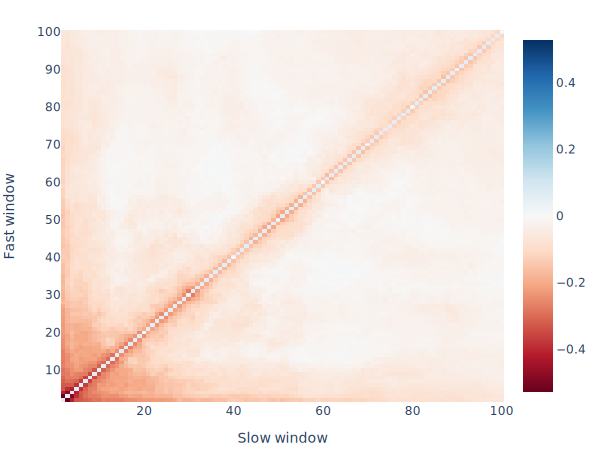

In [42]:
# For example, get mean performance for each window combination over all date ranges
heatmap_index = dmac_roll_perf.index.levels[0]
heatmap_columns = dmac_roll_perf.index.levels[1]
heatmap_df = pd.DataFrame(np.nanmean(dmac_perf_cube, axis=2), index=heatmap_index, columns=heatmap_columns)
heatmap_df = heatmap_df.vbt.make_symmetric()

heatmap_df.vbt.heatmap(
    xaxis_title='Slow window', 
    yaxis_title='Fast window', 
    trace_kwargs=dict(zmid=0, colorscale='RdBu')).show_svg()

This image alone tells much more than the net profit heatmaps we plotted above!

8 20 71 75


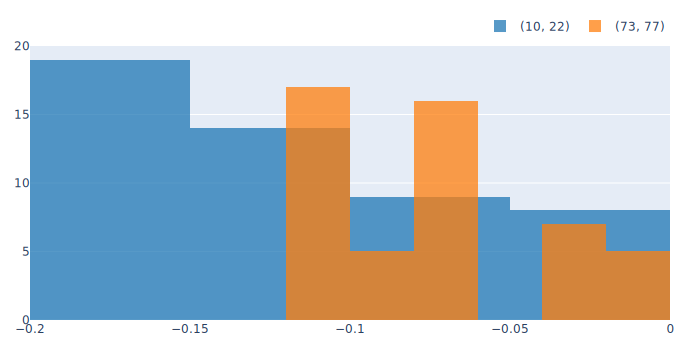

In [43]:
# Or for example, compare a pair of window combinations using a histogram
window_comb1 = (10, 22)
window_comb2 = (73, 77)

# Get index of each window in strat_cube
fast1_idx = np.where(heatmap_df.index == window_comb1[0])[0][0]
slow1_idx = np.where(heatmap_df.columns == window_comb1[1])[0][0]
fast2_idx = np.where(heatmap_df.index == window_comb2[0])[0][0]
slow2_idx = np.where(heatmap_df.columns == window_comb2[1])[0][0]

print(fast1_idx, slow1_idx, fast2_idx, slow2_idx)

dmac_comb1_perf = dmac_perf_cube[fast1_idx, slow1_idx, :]
dmac_comb2_perf = dmac_perf_cube[fast2_idx, slow2_idx, :]

pd.DataFrame({str(window_comb1): dmac_comb1_perf, str(window_comb2): dmac_comb2_perf}).vbt.histplot().show_svg()

Now the fun part.

Is our DMAC strategy really better than a simple random or hold strategy? To make any conclusions, we need to perform multiple tests over multiple time ranges (similar to how we compared window combinations earlier). And to make this experiment fair, all strategies must have the same number of tests. Moreover, the random strategy must have the same number of entry and exit signals as in our DMAC strategy.

In [44]:
%%time
# Hold strategy applied on rolled price
# Entry at the beginning, no exit
hold_entries_roll = pd.DataFrame.vbt.signals.empty_like(dmac_entries_roll)
hold_entries_roll.iloc[0] = True
hold_exits_roll = pd.DataFrame.vbt.signals.empty_like(hold_entries_roll)
hold_exits_roll.iloc[-1] = True

hold_roll_pf = vbt.Portfolio.from_signals(close_roll, hold_entries_roll, hold_exits_roll, freq=freq)

hold_roll_perf = hold_roll_pf.getattr(metric)

print(hold_roll_perf.shape)
print(hold_roll_perf.index)

(242550,)
MultiIndex([( 2,   3,  0),
            ( 2,   3,  1),
            ( 2,   3,  2),
            ( 2,   3,  3),
            ( 2,   3,  4),
            ( 2,   3,  5),
            ( 2,   3,  6),
            ( 2,   3,  7),
            ( 2,   3,  8),
            ( 2,   3,  9),
            ...
            (99, 100, 40),
            (99, 100, 41),
            (99, 100, 42),
            (99, 100, 43),
            (99, 100, 44),
            (99, 100, 45),
            (99, 100, 46),
            (99, 100, 47),
            (99, 100, 48),
            (99, 100, 49)],
           names=['fast_ma_window', 'slow_ma_window', 'split_idx'], length=242550)
Wall time: 4.69 s


In [45]:
%%time
# Random strategy applied on rolled price
# Shuffle entries to get random entry signals of the same shape and cardinality
rand_entries_roll = dmac_entries_roll.vbt.signals.shuffle(seed=seed)

# Must have the same number of signals
pd.testing.assert_series_equal(rand_entries_roll.sum(axis=0), dmac_entries_roll.sum(axis=0))

# If we generate exits the same way as entries, we will get multiple exits between entries
# This is the correct way to generate ONLY ONE exit between two entries
rand_exits_roll = rand_entries_roll.vbt.signals.generate_random_exits(seed=seed)

rand_roll_pf = vbt.Portfolio.from_signals(close_roll, rand_entries_roll, rand_exits_roll, freq=freq)

rand_roll_perf = rand_roll_pf.getattr(metric)

print(rand_roll_perf.shape)
print(rand_roll_perf.index)

(242550,)
MultiIndex([( 2,   3,  0),
            ( 2,   3,  1),
            ( 2,   3,  2),
            ( 2,   3,  3),
            ( 2,   3,  4),
            ( 2,   3,  5),
            ( 2,   3,  6),
            ( 2,   3,  7),
            ( 2,   3,  8),
            ( 2,   3,  9),
            ...
            (99, 100, 40),
            (99, 100, 41),
            (99, 100, 42),
            (99, 100, 43),
            (99, 100, 44),
            (99, 100, 45),
            (99, 100, 46),
            (99, 100, 47),
            (99, 100, 48),
            (99, 100, 49)],
           names=['fast_ma_window', 'slow_ma_window', 'split_idx'], length=242550)
Wall time: 10.9 s


In [46]:
dmac_roll_perf.mean(), hold_roll_perf.mean(), rand_roll_perf.mean()

(-0.05075210158160646, -0.02744723945038744, -0.060779434815687206)

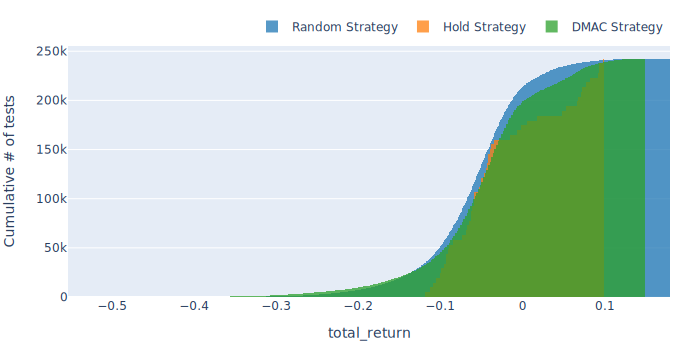

In [47]:
pd.DataFrame({
    'Random Strategy': rand_roll_perf, 
    'Hold Strategy': hold_roll_perf,
    'DMAC Strategy': dmac_roll_perf, 
}).vbt.histplot(
    xaxis_title=metric,
    yaxis_title='Cumulative # of tests',
    trace_kwargs=dict(cumulative_enabled=True)).show_svg()

The lower the curve, the better.

To get more insights, we should compare them over time.

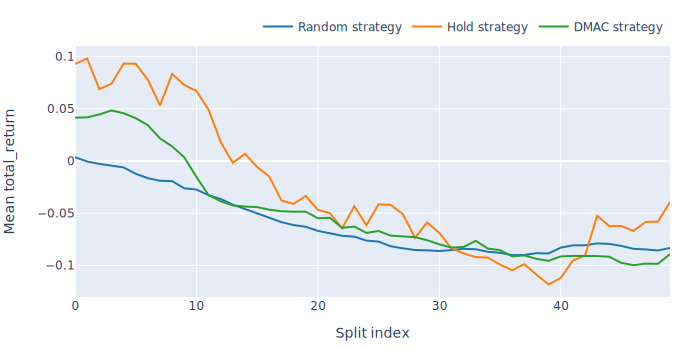

In [48]:
pd.DataFrame({
    'Random strategy': rand_roll_perf.groupby('split_idx').mean(), 
    'Hold strategy': hold_roll_perf.groupby('split_idx').mean(),
    'DMAC strategy': dmac_roll_perf.groupby('split_idx').mean()
}).vbt.plot(
    xaxis_title='Split index',
    yaxis_title='Mean %s' % metric).show_svg()

You can go further and plot the above graph for each window combination.

In [49]:
windows_slider = widgets.IntRangeSlider(
    value=(fast_window, slow_window),
    min=min_window,
    max=max_window,
    step=1,
    layout=dict(width='500px'),
    continuous_update=True
)

scatter = vbt.plotting.Scatter(
    trace_names=['Random strategy', 'Hold strategy', 'DMAC strategy'],
    x_labels=dmac_roll_perf.index.get_level_values('split_idx').unique(),
    xaxis_title='Split index',
    yaxis_title='Mean %s' % metric
)
scatter_img = widgets.Image(
    format='png',
    width=scatter.fig.layout.width,
    height=scatter.fig.layout.height
)

def on_value_change(value):
    fast_window, slow_window = value['new']
    
    # Build boolean mask that acts like a filter
    fast_windows = dmac_roll_perf.index.get_level_values('fast_ma_window')
    slow_windows = dmac_roll_perf.index.get_level_values('slow_ma_window')
    mask = (fast_windows == fast_window) & (slow_windows == slow_window)
    
    # Return raw data
    new_data = np.asarray([
        rand_roll_perf[mask].groupby('split_idx').mean(),
        hold_roll_perf[mask].groupby('split_idx').mean(),
        dmac_roll_perf[mask].groupby('split_idx').mean()
    ]).transpose()

    # Update figures
    scatter.update(new_data)
    scatter_img.value = scatter.fig.to_image(format="png")
    
windows_slider.observe(on_value_change, names='value')
on_value_change({'new': windows_slider.value}) # default range

dashboard = widgets.VBox([
    widgets.HBox([
        widgets.Label('Fast and slow window:'), 
        windows_slider
    ]), 
    scatter_img
])
dashboard

In [50]:
dashboard.close() # after using, release memory and notebook metadata

In [51]:
import gc

gc.collect()

1350